In [2]:
import sys
sys.path.insert(1, '../scripts')

In [3]:
## Basics
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import parseaf as pa
#import tempparse as paf

## Logistic regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [5]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [6]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

In [7]:
def get_cnf_freq(cnf_mat):
    cnf_freq = cnf_mat / cnf_mat.sum(axis=1)[:, np.newaxis]
    return cnf_freq

In [8]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## Logistic regression with AlphaFold data

In [9]:
allregions = pd.read_csv('../../data/af_regions/sc_af_regions_all.csv')

In [10]:
for aa in states:
    allregions['freq_'+aa] = allregions.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [11]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = allregions[featurecol]
y = allregions['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_all = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9246841593780369

In [12]:
df_lr = pd.DataFrame(columns=['aa','coef'])
for i in range(20):
    df_lr = df_lr.append({'aa': states[i], 'coef': logreg.coef_[0][i]}, ignore_index=True)
df_lr = df_lr.sort_values(by='coef', ascending=False, key=abs)

## Logistic regression model using PDB data

In [13]:
allregions = pd.read_csv('../../data/pdb_regions.csv')

In [14]:
for aa in states:
    allregions['freq_'+aa] = allregions.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [15]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = allregions[featurecol]
y = allregions['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg_pdb = LogisticRegression()
logreg_pdb.fit(X_train, y_train)
y_pred = logreg_pdb.predict(X_test)
cnf_all = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9304981174001605

In [16]:
df_lr_pdb = pd.DataFrame(columns=['aa','coef'])
for i in range(20):
    df_lr_pdb = df_lr_pdb.append({'aa': states[i], 'coef': logreg_pdb.coef_[0][i]}, ignore_index=True)
df_lr_pdb = df_lr_pdb.sort_values(by='coef', ascending=False, key=abs)

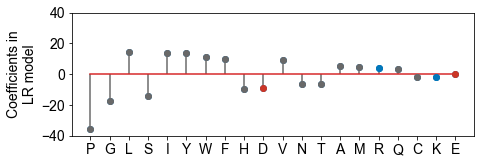

In [17]:
plt.figure(figsize=(6.9,2.5))
plt.stem(df_lr_pdb['aa'], df_lr_pdb['coef'],
         linefmt='dimgrey')

for index,row in df_lr_pdb.iterrows():
    aa = row['aa']
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(aa, row['coef'], marker='o', color=color, zorder=3)
plt.ylim(-40, 40)
    
plt.ylabel('Coefficients in\nLR model')
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.show()

## LR coefficients against helix propensity

In [18]:
df_hp = pd.read_csv('../../data/misc/helix_propensity_pace1998.txt')
h_propensity = {}
for index, row in df_hp.iterrows():
    h_propensity[row['aa']] = row['hp']

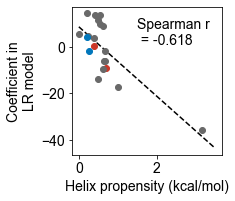

In [30]:
plt.figure(figsize=(3.4,3.02))

coefs = logreg_pdb.coef_.tolist()[0]
for i in range(20):
    aa = states[i]
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(h_propensity[aa], coefs[i],
                color=color, zorder=3)

plt.xlabel('Helix propensity (kcal/mol)')
plt.ylabel('Coefficient in\nLR model')
corr = stats.spearmanr(list(h_propensity.values()), logreg_pdb.coef_[0].tolist())
reg = LinearRegression().fit(np.asarray(list(h_propensity.values())).reshape(-1, 1),
                             np.asarray(logreg_pdb.coef_[0].tolist()).reshape(-1, 1))
x = np.arange(0, 3.5, 0.01).reshape(-1, 1)
plt.plot(x, reg.predict(x), color='black', linestyle='--')

plt.text(1.5, 1, "Spearman r\n = " + '{0:.3g}'.format(corr.correlation))
plt.tight_layout()
plt.show()

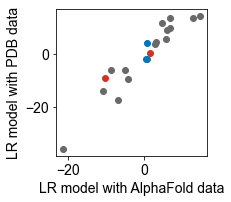

In [32]:
plt.figure(figsize=(3.2,3))

coefs1 = logreg.coef_.tolist()[0]
coefs2 = logreg_pdb.coef_.tolist()[0]
for i in range(20):
    aa = states[i]
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(coefs1[i], coefs2[i],
                color=color, zorder=3)

plt.xlabel('LR model with AlphaFold data')
plt.ylabel('LR model with PDB data')
plt.tight_layout()
plt.show()

## Using PDB AF model to predict secondary structure of highly charged regions

In [33]:
df_hc = pd.read_csv('../../data/charged_regions/cr_filtered_aflabel.csv')

In [35]:
def append_percent_aa(row, aa):
    seq = row['region.seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

In [36]:
for aa in states:
    df_hc['freq_'+aa] = df_hc.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [37]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X_hc = df_hc[featurecol]
y_hc = df_hc['label']
y_pred_hc = logreg_pdb.predict(X_hc)
cnf_hc = metrics.confusion_matrix(y_hc, y_pred_hc)
accuracy = metrics.accuracy_score(y_hc, y_pred_hc)
accuracy

0.89272030651341

## Using PDB AF model to predict secondary structure of highly charged regions

In [38]:
df_hc = pd.read_csv('../../data/charged_regions/cr_trimmed_filtered_aflabel.csv')

In [39]:
def append_percent_aa(row, aa):
    seq = row['region.seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

In [40]:
for aa in states:
    df_hc['freq_'+aa] = df_hc.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [41]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X_hc = df_hc[featurecol]
y_hc = df_hc['label']
y_pred_hc = logreg_pdb.predict(X_hc)
cnf_hc = metrics.confusion_matrix(y_hc, y_pred_hc)
accuracy = metrics.accuracy_score(y_hc, y_pred_hc)
accuracy

0.9328493647912885